# Result analysis

### table of content
1. [Dependencies and src](#dependencies-and-src)
2. [Training and Validation set analysis](#training-and-validation-set-analysis)
3. [Evolution of accuracy per class](#evolution-of-accuracy-per-class)
4. [Confidence vs accuracy](#confidence-vs-accuracy)
5. [Ever-mislabeled sampels](#ever-mislabeled-samples)
6. [Creating confusion matrices of ML methods](#creating-confusion-matrices-of-ml-methods)
7. [Inference analysis](#inference-analysis)
8. [Distribution from list of dropped samples](#distribution-from-list-of-dropped-samples)

### Dependencies and src

In [1]:
import os
import sys
import numpy as np
import pickle
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sn
import rasterio
from tqdm import tqdm

sys.path.insert(0,'D:\GitHubProjects\STDL_Classifier')
from src.visualization import show_metrics_evolution

In [2]:
# source file
src_dir = "../results/trainings_archive/20241114_num_epoch_100_frac_100_scratch_best_model_conf_512_scratch"
#src_dir = "../results/trainings/20241121_num_epoch_3_frac_10_test_no_backbone_no_aspp_2"
log_dir = os.path.join(src_dir, "logs")
img_dir = os.path.join(src_dir, 'images')
dataset_dir = "../data/dataset"

In [3]:
with open(os.path.join(log_dir,'samp_logs.pickle'), 'rb') as input_file:
    samp_logs = pickle.load(input_file)

df_dataset = pd.read_csv(os.path.join(dataset_dir, 'dataset.csv'), sep=';')

epoch = 51
train_res = pd.DataFrame(samp_logs[epoch]['train'])
val_res = pd.DataFrame(samp_logs[epoch]['val'])
print(train_res)

                        egid  target  pred
0              302061918_180       3     3
1        1015374_90_flip_hor       4     4
2     295102365_180_flip_hor       2     4
3       2036485_270_flip_hor       1     1
4     295139792_270_flip_hor       3     3
...                      ...     ...   ...
9787   302024782_90_flip_hor       3     2
9788      295076219_flip_hor       0     1
9789  302020405_270_flip_hor       2     0
9790  295138387_270_flip_hor       1     1
9791               295129025       0     0

[9792 rows x 3 columns]


### training and validation set analysis

In [4]:
print(f"Size of training set: {len(train_res)}")
print(f"Size of validation set: {len(val_res)}")
print(f"Columns = {val_res.columns.tolist()}")
overlapping = val_res.loc[val_res['egid'].isin(train_res.egid.tolist())]
print('-' * 10)
print(f"Number of overlapping samples (problem if not zero!): {len(overlapping)}")
print('-' * 10)

class_labels = {0:'bare', 1:'terrace',2:'spontaneous',3:'extensive',4:'lawn',5:'intensive'}
# Count per class
print("Count per class:")
print(" - training set:")
for idx, label in class_labels.items():
    count = len(train_res[train_res.target == idx])
    print(f"\t{label}: {count} samples")
print(" - validation set:")
for idx, label in class_labels.items():
    count = len(val_res[val_res.target == idx])
    print(f"\t{label}: {count} samples")

# frac per class
print("Fraction per class:")
print(" - training set:")
for idx, label in class_labels.items():
    frac = len(train_res[train_res.target == idx]) / len(train_res)
    print(f"\t{label}: {int(frac * 100)}%")
print(" - validation set:")
for idx, label in class_labels.items():
    frac = len(val_res[val_res.target == idx]) / len(val_res)
    print(f"\t{label}: {int(frac * 100)}%")

print('-' * 10)
print("Fraction between sets:")
print(" - training set:")
for idx, label in class_labels.items():
    tot = pd.concat([train_res, val_res])
    tot = tot[tot.target == idx]
    frac = len(train_res[train_res.target == idx]) / len(tot)
    print(f"\t{label}: {int(frac * 100)}%")
print(" - validation set:")
for idx, label in class_labels.items():
    tot = pd.concat([train_res, val_res])
    tot = tot[tot.target == idx]
    frac = len(val_res[val_res.target == idx]) / len(tot)
    print(f"\t{label}: {int(frac * 100)}%")

Size of training set: 9792
Size of validation set: 1008
Columns = ['egid', 'target', 'pred']
----------
Number of overlapping samples (problem if not zero!): 0
----------
Count per class:
 - training set:
	bare: 3456 samples
	terrace: 1356 samples
	spontaneous: 1138 samples
	extensive: 2703 samples
	lawn: 612 samples
	intensive: 527 samples
 - validation set:
	bare: 740 samples
	terrace: 48 samples
	spontaneous: 41 samples
	extensive: 145 samples
	lawn: 22 samples
	intensive: 12 samples
Fraction per class:
 - training set:
	bare: 35%
	terrace: 13%
	spontaneous: 11%
	extensive: 27%
	lawn: 6%
	intensive: 5%
 - validation set:
	bare: 73%
	terrace: 4%
	spontaneous: 4%
	extensive: 14%
	lawn: 2%
	intensive: 1%
----------
Fraction between sets:
 - training set:
	bare: 82%
	terrace: 96%
	spontaneous: 96%
	extensive: 94%
	lawn: 96%
	intensive: 97%
 - validation set:
	bare: 17%
	terrace: 3%
	spontaneous: 3%
	extensive: 5%
	lawn: 3%
	intensive: 2%


In [5]:
print("NOW WITHOUT DATA AUGMENTATION")
train_res = pd.DataFrame(samp_logs[epoch]['train'])
train_res.to_csv('../test/test_egids_in_trainingset_from_samplogs.csv', sep=';')
val_res.to_csv('../test/test_egids_in_validationset_from_samplogs.csv', sep=';')
for id, samp in enumerate(train_res.itertuples()):
    if len(str(samp.egid).split('_')) > 1:
        train_res = train_res.drop(index=samp.Index, axis=0)
train_res.egid = train_res.egid.astype(int)
print(train_res.egid.sort_values())
print(len(train_res.egid.unique()))

print(f"Size of training set: {len(train_res)}")
print(f"Size of validation set: {len(val_res)}")
print(f"Columns = {val_res.columns.tolist()}")
overlapping = val_res.loc[val_res['egid'].isin(train_res.egid.tolist())]
print('-' * 10)
print(f"Number of overlapping samples (problem if not zero!): {len(overlapping)}")
print('-' * 10)

class_labels = {0:'bare', 1:'terrace',2:'spontaneous',3:'extensive',4:'lawn',5:'intensive'}
# Count per class
print("Count per class:")
print(" - training set:")
for idx, label in class_labels.items():
    count = len(train_res[train_res.target == idx])
    print(f"\t{label}: {count} samples")
print(" - validation set:")
for idx, label in class_labels.items():
    count = len(val_res[val_res.target == idx])
    print(f"\t{label}: {count} samples")

# frac per class
print("Fraction per class:")
print(" - training set:")
for idx, label in class_labels.items():
    frac = len(train_res[train_res.target == idx]) / len(train_res)
    print(f"\t{label}: {int(frac * 100)}%")
print(" - validation set:")
for idx, label in class_labels.items():
    frac = len(val_res[val_res.target == idx]) / len(val_res)
    print(f"\t{label}: {int(frac * 100)}%")

print('-' * 10)
print("Fraction between sets:")
print(" - training set:")
for idx, label in class_labels.items():
    tot = pd.concat([train_res, val_res])
    tot = tot[tot.target == idx]
    frac = len(train_res[train_res.target == idx]) / len(tot)
    print(f"\t{label}: {int(frac * 100)}%")
print(" - validation set:")
for idx, label in class_labels.items():
    tot = pd.concat([train_res, val_res])
    tot = tot[tot.target == idx]
    frac = len(val_res[val_res.target == idx]) / len(tot)
    print(f"\t{label}: {int(frac * 100)}%")

NOW WITHOUT DATA AUGMENTATION
5707       140638
4168       140644
5797       140650
797        140901
1189       141188
          ...    
2394    302064402
9762    302064435
451     302065390
37      302066434
9610    302067554
Name: egid, Length: 2368, dtype: int64
2368
Size of training set: 2368
Size of validation set: 1008
Columns = ['egid', 'target', 'pred']
----------
Number of overlapping samples (problem if not zero!): 0
----------
Count per class:
 - training set:
	bare: 1728 samples
	terrace: 113 samples
	spontaneous: 95 samples
	extensive: 337 samples
	lawn: 51 samples
	intensive: 44 samples
 - validation set:
	bare: 740 samples
	terrace: 48 samples
	spontaneous: 41 samples
	extensive: 145 samples
	lawn: 22 samples
	intensive: 12 samples
Fraction per class:
 - training set:
	bare: 72%
	terrace: 4%
	spontaneous: 4%
	extensive: 14%
	lawn: 2%
	intensive: 1%
 - validation set:
	bare: 73%
	terrace: 4%
	spontaneous: 4%
	extensive: 14%
	lawn: 2%
	intensive: 1%
----------
Fraction be

In [6]:
# small test
df = pd.DataFrame({
    'a': [1,2,3,3,4,3,1],
    'b': [1,2,3,4,5,6,7]
})
print(len(df))
print(len(df.a.unique()))
print(len(df.b.unique()))

7
4
7


In [7]:
# look at the gpkg gile
roofs = gpd.read_file("../data/sources/gt_matching_roofs.gpkg")
print(len(roofs))
dataset = pd.read_csv('../data/dataset/dataset.csv', sep=';')
print(len(dataset))
dataset = dataset.loc[dataset.EGID.astype('string') == dataset.original_egid.astype('string')]
print(len(dataset))

3406
6134
3386


### show different metrics evolution

In [8]:
src_metrics_train = os.path.join(log_dir, 'metrics_train.csv')
src_metrics_val = os.path.join(log_dir, 'metrics_val.csv')
metrics_train = pd.read_csv(src_metrics_train, sep=';')
metrics_val = pd.read_csv(src_metrics_val, sep=';')

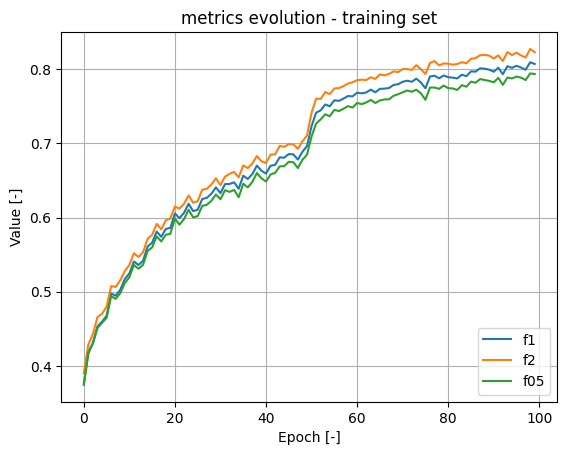

In [9]:
# show training results
show_metrics_evolution(
    data=metrics_train[['epoch','f1','f2','f05']],
    target_src='derp', 
    title='metrics evolution - training set', 
    do_save=False, 
    do_show=True
    )

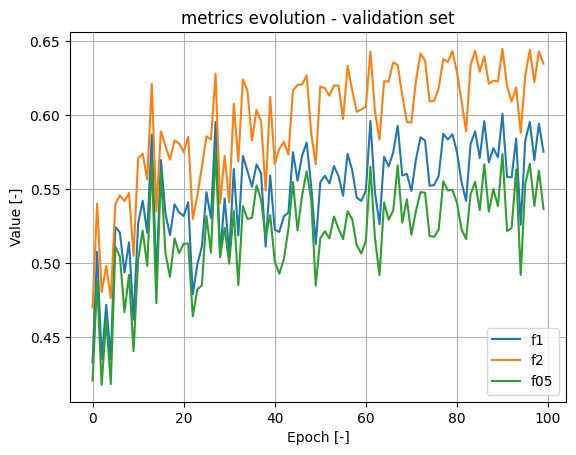

In [10]:
# show validation results
show_metrics_evolution(
    data=metrics_val[['epoch','f1','f2','f05']],
    target_src='derp', 
    title='metrics evolution - validation set', 
    do_save=False, 
    do_show=True
    )

### evolution of accuracy per class

100%|██████████| 100/100 [00:01<00:00, 94.44it/s]


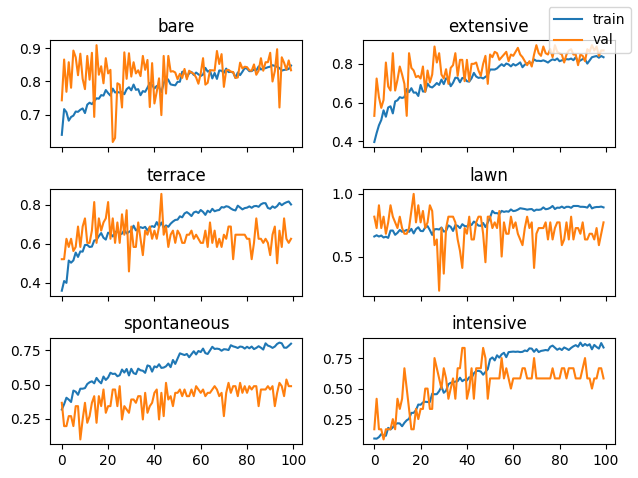

In [11]:
num_epochs = len(samp_logs)
modes = ['train','val']
acc_per_cat = {y: {x:[] for x in range(6)} for y in modes}
for epoch in tqdm(range(num_epochs), total=num_epochs):
    res = {mode: pd.DataFrame(samp_logs[epoch][mode]) for mode in modes}
    for mode in modes:
        for x in range(6):
            size_tot_class = len(res[mode][res[mode].target == x])
            acc_per_cat[mode][x].append(len(res[mode][(res[mode].target == x) & (res[mode].target == res[mode].pred)])/size_tot_class)


fig, axs = plt.subplots(3, 2, sharex=True)
titles = ['bare', 'terrace','spontaneous', 'extensive', 'lawn', 'intensive']
for i in range(6):
    for mode in modes:
        leg = mode if i == 0 else None
        axs[i%3, i//3].plot(acc_per_cat[mode][i], label=leg)
    axs[i%3, i//3].set_title(titles[i])
fig.legend()
plt.tight_layout()
plt.show()
plt.close()

    

### Confidence vs Accuracy

In [12]:
print(samp_logs[2]['train']['pred_conf'])

KeyError: 'pred_conf'

### Ever-mislabeled samples

100%|██████████| 100/100 [00:00<00:00, 2022.76it/s]


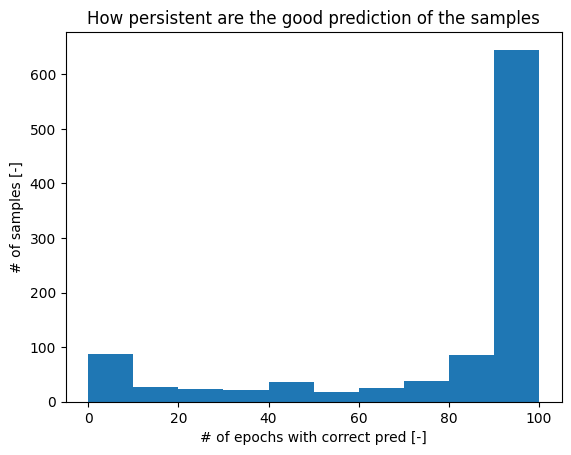

In [14]:
num_epochs = 100
modes = ['train','val']
#acc_per_cat = {y: {x:[] for x in range(6)} for y in modes}
egids = samp_logs[12]['val']['egid']

egids_count_wins = {egid: 0 for egid in egids}
for epoch in tqdm(range(num_epochs), total=num_epochs):
    for idx, egid in enumerate(egids):
        #print(int(samp_logs[epoch]['val']['pred'][idx] == samp_logs[epoch]['val']['target'][idx]))
        egids_count_wins[egid] += int(samp_logs[epoch]['val']['pred'][idx] == samp_logs[epoch]['val']['target'][idx])

df_good_preds_per_samp = pd.DataFrame({
    'egid': egids,
    'acc': egids_count_wins.values(),
})
df_good_preds_per_samp.to_csv('./ever_mislabeled_samples.csv', sep=';', index=None)

fig = plt.figure()
plt.hist(egids_count_wins.values())
plt.xlabel('# of epochs with correct pred [-]')
plt.ylabel('# of samples [-]')
plt.title('How persistent are the good prediction of the samples')
plt.show()

In [16]:
# resources
dir_data = "../data/dataset"
threshold = 25

# show bad students
least_good_egids = df_good_preds_per_samp.loc[df_good_preds_per_samp.acc <= threshold].egid.values
print(f"Number of bad samples (good preds less than 25 times) : {len(least_good_egids)}")
# find samples:
lst_egids_src = []
for egid in least_good_egids:
    for r, d, f in os.walk(dir_data):
        for file in f:
            if file.split('.')[0] == str(egid) and file.split('.')[-1] == 'tif':
                lst_egids_src.append(os.path.join(r, file))
print(f"Number of those samples matching a picture: {len(lst_egids_src)}")
print(lst_egids_src)

Number of bad samples (good preds less than 25 times) : 132
Number of those samples matching a picture: 132
['../data/dataset\\bare\\2366422.tif', '../data/dataset\\bare\\1014801.tif', '../data/dataset\\bare\\295100262.tif', '../data/dataset\\bare\\295524723.tif', '../data/dataset\\bare\\2749149.tif', '../data/dataset\\bare\\169940.tif', '../data/dataset\\bare\\2374974.tif', '../data/dataset\\bare\\1008622.tif', '../data/dataset\\bare\\295081459.tif', '../data/dataset\\bare\\1008579.tif', '../data/dataset\\bare\\1005691.tif', '../data/dataset\\bare\\295077154.tif', '../data/dataset\\bare\\295070567.tif', '../data/dataset\\bare\\295077775.tif', '../data/dataset\\bare\\157405.tif', '../data/dataset\\bare\\302022580.tif', '../data/dataset\\bare\\295105721.tif', '../data/dataset\\bare\\295094282.tif', '../data/dataset\\bare\\157712.tif', '../data/dataset\\bare\\302022768.tif', '../data/dataset\\bare\\295070607.tif', '../data/dataset\\bare\\2035711.tif', '../data/dataset\\bare\\295075665.ti

In [17]:
# stats
dict_letter_to_class = {
    'b': 'bare',
    't': 'terrace',
    's': 'spontaneous',
    'e': 'extensive',
    'l': 'lawn',
    'i': 'intensive',
}
df_least_goods = df_dataset.loc[df_dataset.EGID.astype('string').isin(least_good_egids)]
print("Number of samples per class:")
for idx, cat in enumerate(dict_letter_to_class.keys()):
    num_in_class = len(df_least_goods.loc[df_least_goods['class'] == cat])
    print(f"{dict_letter_to_class[cat]} : {num_in_class}")

Number of samples per class:
bare : 77
terrace : 13
spontaneous : 21
extensive : 14
lawn : 4
intensive : 3


In [24]:
do_process = False
if do_process:
    fig = plt.figure()
    for idx, img_src in enumerate(lst_egids_src):
        img_arr = rasterio.open(img_src).read()
        plt.imshow(np.moveaxis(img_arr[1:4,:], 0, 2))
        egid = least_good_egids[idx]
        cat = df_dataset.loc[df_dataset.EGID == egid]['class'].values[0]
        cat = dict_letter_to_class[cat]
        count = df_good_preds_per_samp.loc[df_good_preds_per_samp.egid == egid].acc.values[0]
        plt.title(f"{egid} - class: {cat}, count: {count}")
        plt.show()

In [25]:
# save samples in gpkg file
roofs = gpd.read_file('../data/sources/gt_tot.gpkg')
roofs_least_good = roofs.loc[roofs.EGID.astype(int).astype('string').isin(list(df_least_goods.EGID.values))]
roofs_least_good['class'] = df_least_goods['class'].values
print(roofs_least_good.head())
roofs_least_good.to_file('./worst_pred_samples.gpkg')


            EGID  veg_old                    year  veg_new class  confidence  \
24     1015390.0      1.0  Période de 1961 à 1970      1.0     i         1.0   
34     1014801.0      0.0  Période de 1946 à 1960      0.0     b         1.0   
72   295111284.0      0.0  Période de 2006 à 2010      0.0     b         NaN   
121  295121084.0      0.0  Période de 2006 à 2010      0.0     b         NaN   
330  295087551.0      1.0  Période de 2001 à 2005      1.0     s         1.0   

    comments  complex_ro surface_ca  unID        area cls_agg  veg_new_2  \
24      None         0.0          1  1471  256.581696    None          1   
34      None         NaN          0  1481  362.907557      bt          0   
72      None         NaN          0  1519  304.500359      bt          0   
121     None         NaN          0  1568  342.104271      bt          0   
330     None         0.0          3  1777   49.441273       s          1   

    class_2 confusion class_3  veg_new_3  \
24        i      N

### creating confusion matrices of ML methods

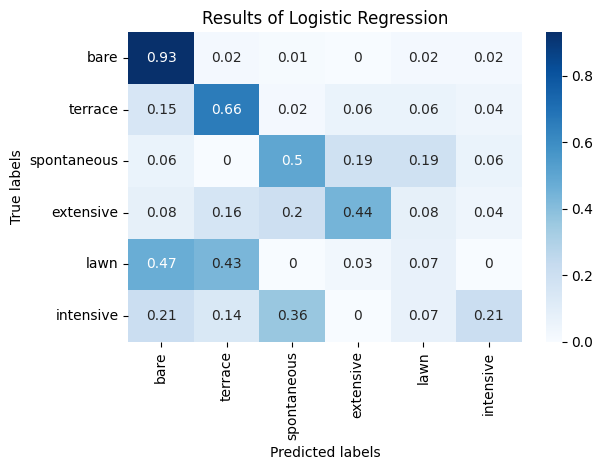

In [26]:
data_LR = pd.read_csv("../data/test/cf_multi_LR.csv", sep=';').drop(['cat','tot','recall'], axis=1)
arr_data_LR = np.array(data_LR)

arr_data_LR_norm = np.round([x/np.sum(x) for x in arr_data_LR],2)

class_labels = ['bare','terrace','spontaneous','extensive','lawn','intensive']
df_conf_mat_LR = pd.DataFrame(arr_data_LR_norm, index = class_labels, columns=class_labels)
fig = plt.figure()
sn.heatmap(df_conf_mat_LR, annot=True, cmap=sn.color_palette("Blues", as_cmap=True))
ax = plt.gca()
ax.set_title('Results of Logistic Regression')

plt.tight_layout()
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
fig.tight_layout()
plt.show()
fig.savefig("../results/trainings/ML_results/conf_mat_LR.png")

     b   e  i   l  s  t
0  846   5  0   0  0  0
1   31  95  1   2  1  0
2    7   0  6   2  0  1
3    6   6  1  10  0  2
4   16  14  0   0  0  0


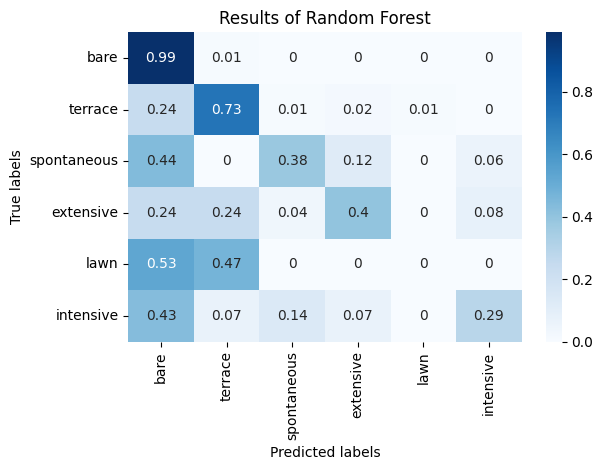

In [27]:
data_RF = pd.read_csv("../data/test/cf_multi_RF.csv", sep=';').drop(['cat'], axis=1)
print(data_RF.head())

arr_data_RF = np.array(data_RF)

arr_data_RF_norm = np.round([x/np.sum(x) for x in arr_data_RF],2)

class_labels = ['bare','terrace','spontaneous','extensive','lawn','intensive']
df_conf_mat_RF = pd.DataFrame(arr_data_RF_norm, index = class_labels, columns=class_labels)
fig = plt.figure()
sn.heatmap(df_conf_mat_RF, annot=True, cmap=sn.color_palette("Blues", as_cmap=True))
ax = plt.gca()
ax.set_title('Results of Random Forest')

plt.tight_layout()
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
fig.tight_layout()
plt.show()
fig.savefig("../results/trainings/ML_results/conf_mat_RF.png")


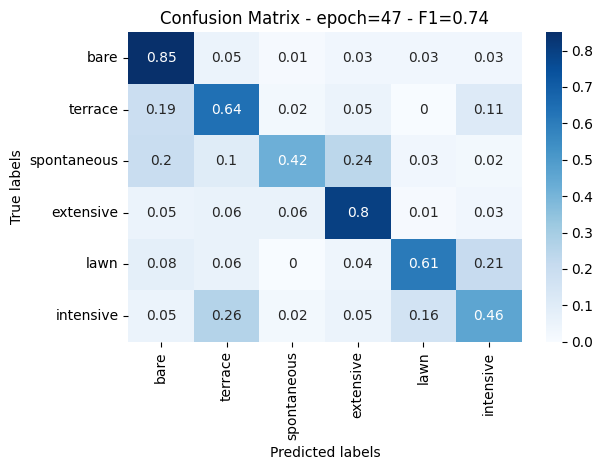

In [28]:
data_DL = pd.read_csv("../data/test/cf_multi_DL.csv", sep=';').drop(['cat'], axis=1)

arr_data_DL = np.array(data_DL)

arr_data_DL_norm = np.round([x/np.sum(x) for x in arr_data_DL],2)

class_labels = ['bare','terrace','spontaneous','extensive','lawn','intensive']
df_conf_mat_DL = pd.DataFrame(arr_data_DL_norm, index = class_labels, columns=class_labels)
fig = plt.figure()
sn.heatmap(df_conf_mat_DL, annot=True, cmap=sn.color_palette("Blues", as_cmap=True))
ax = plt.gca()
ax.set_title('Confusion Matrix - epoch=47 - F1=0.74')

plt.tight_layout()
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
fig.tight_layout()
plt.show()
fig.savefig("../results/trainings/ML_results/conf_mat_DL.png")

### Inference analysis

In [29]:
src_inference = r"D:\GitHubProjects\STDL_Classifier\results\inferences\20241119_inference_model_scratch_20241114_final_product\infs_concat_roofs_join_green_preds_final_product.csv"
data_inf = pd.read_csv(src_inference, sep=';')
dict_multi_char_to_name = {
    'b': 'bare',
    't': 'terrace',
    's': 'spontaneous',
    'e': 'extensive',
    'l': 'lawn',
    'i': 'intensive',
}
dict_binary_char_to_name = {
    0: 'bare',
    1: 'vegetated',
    'b': 'bare',
    'v': 'vegetated',
}
data_inf.replace({'pred':dict_binary_char_to_name, 'Preds_multi': dict_multi_char_to_name, 'Preds_binary': dict_binary_char_to_name}, inplace=True)
print(data_inf.head())

    EGID  area_green        area  area_ratio  pred  proba_bare  proba_veg  \
0  76869    5.000000   58.589647    0.085339  bare    0.788877   0.211123   
1  76870    6.140000   58.794761    0.104431  bare    0.805845   0.194155   
2  76871    8.710000  146.118820    0.059609  bare    0.880794   0.119206   
3  76872    8.070000   99.352738    0.081226  bare    0.846794   0.153206   
4  76873    4.751215   98.976031    0.048004  bare    0.560140   0.439860   

     year                                           geometry Preds_multi  \
0  1990.0  MULTIPOLYGON (((2697012.022288635 1233286.2483...   extensive   
1  1990.0  MULTIPOLYGON (((2697019.928350504 1233277.8398...        bare   
2  1990.0  MULTIPOLYGON (((2697025.278648097 1233259.8285...        bare   
3  1990.0  MULTIPOLYGON (((2697021.00802275 1233224.17243...   extensive   
4  1990.0  MULTIPOLYGON (((2697010.472980754 1233224.9490...        bare   

  Preds_binary  Preds_multi_conf  Preds_binary_conf  
0    vegetated          0.

In [30]:
# repartition
dict_per_cat_multi = data_inf[['Preds_multi','EGID']].groupby(['Preds_multi']).count().EGID.to_dict()
dict_per_cat_bin_ml = data_inf[['pred','EGID']].groupby(['pred']).count().EGID.to_dict()
dict_per_cat_bin_dl = data_inf[['Preds_binary','EGID']].groupby(['Preds_binary']).count().EGID.to_dict()
print("Preds DL Multi:\n", dict_per_cat_multi)
print("\nPreds DL Binary:\n", dict_per_cat_bin_dl)
print("\nPreds ML Binary:\n", dict_per_cat_bin_ml)

Preds DL Multi:
 {'bare': 4640, 'extensive': 1490, 'intensive': 544, 'lawn': 291, 'spontaneous': 1162, 'terrace': 1268}

Preds DL Binary:
 {'bare': 6663, 'vegetated': 2732}

Preds ML Binary:
 {'bare': 8338, 'vegetated': 1057}


<Axes: >

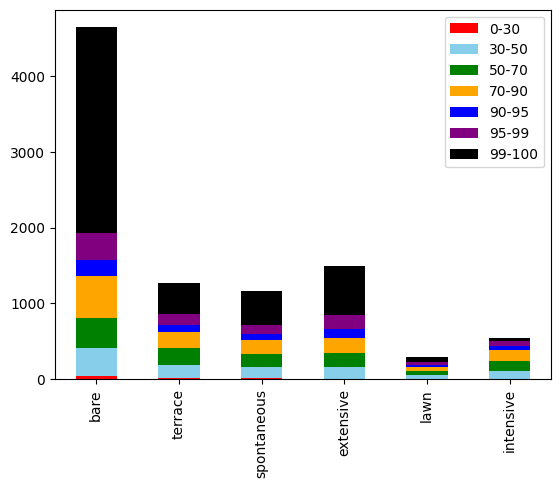

In [31]:
# confidence - multi
dict_preds = {
    '0-30':[],
    '30-50':[],
    '50-70':[],
    '70-90':[],
    '90-95':[],
    '95-99':[],
    '99-100': [],
}
arr_values = np.zeros((6,7))
list_ranges = [0, .3, .5, .7, .9, .95, .99, 1.0]
list_classes = ['bare', 'terrace', 'spontaneous', 'extensive', 'lawn', 'intensive']

for id_cat in range(len(list_ranges) -1):
    for i in range(len(list_classes)):
        list_values = list(data_inf.loc[data_inf.Preds_multi == list_classes[i], 'Preds_multi_conf'].values)
        arr_values[i, id_cat] = len([x for x in list_values if x > list_ranges[id_cat] and x <= list_ranges[id_cat + 1]])

dict_preds = {x:arr_values[:,val] for (x,val) in zip(dict_preds.keys(), range(7))}
pd.DataFrame(dict_preds, index=list_classes).plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green', 'orange', 'blue', 'purple', 'black'])

<Axes: >

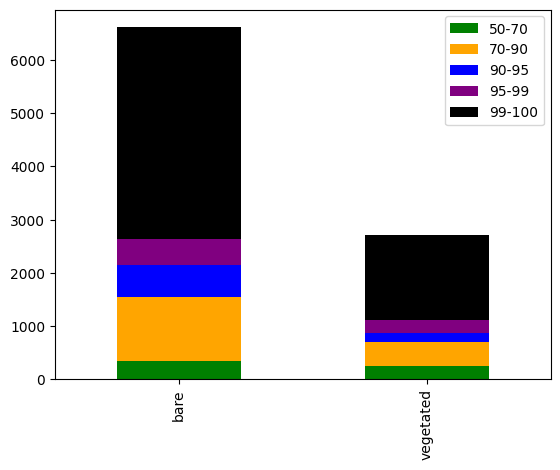

In [32]:
# confidence - multi
dict_preds = {
    '50-70':[],
    '70-90':[],
    '90-95':[],
    '95-99':[],
    '99-100': [],
}
arr_values = np.zeros((2,5))
list_ranges = [.5, .7, .9, .95, .99, 1.0]
list_classes = ['bare', 'vegetated']

for id_cat in range(len(list_ranges) -1):
    for i in range(len(list_classes)):
        list_values = list(data_inf.loc[data_inf.Preds_binary == list_classes[i], 'Preds_binary_conf'].values)
        arr_values[i, id_cat] = len([x for x in list_values if x > list_ranges[id_cat] and x <= list_ranges[id_cat + 1]])

dict_preds = {x:arr_values[:,val] for (x,val) in zip(dict_preds.keys(), range(5))}
pd.DataFrame(dict_preds, index=list_classes).plot(kind='bar', stacked=True, color=['green', 'orange', 'blue', 'purple', 'black'])


Preds DL Binary:
 {'bare': 8338, 'vegetated': 1057}

Preds ML Binary:
 {'bare': 6663, 'vegetated': 2732}


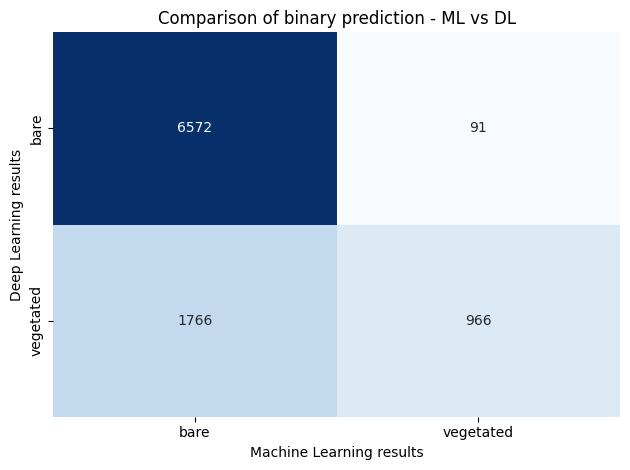

In [29]:
# repartition
dict_per_cat_bin_ml = data_inf[['pred','EGID']].groupby(['pred']).count().EGID.to_dict()
dict_per_cat_bin_dl = data_inf[['Preds_binary','EGID']].groupby(['Preds_binary']).count().EGID.to_dict()
print("\nPreds DL Binary:\n", dict_per_cat_bin_ml)
print("\nPreds ML Binary:\n", dict_per_cat_bin_dl)

# comparison
DL_bare_ML_bare = len(data_inf.loc[(data_inf.pred == 'bare') & (data_inf.Preds_binary == 'bare')])
DL_bare_ML_vege = len(data_inf.loc[(data_inf.pred == 'vegetated') & (data_inf.Preds_binary == 'bare')])
DL_vege_ML_bare = len(data_inf.loc[(data_inf.pred == 'bare') & (data_inf.Preds_binary == 'vegetated')])
DL_vege_ML_vege = len(data_inf.loc[(data_inf.pred == 'vegetated') & (data_inf.Preds_binary == 'vegetated')])
arr_plot = [[DL_bare_ML_bare, DL_bare_ML_vege],[DL_vege_ML_bare, DL_vege_ML_vege]]
df_plot = pd.DataFrame(arr_plot, index=['bare', 'vegetated'], columns=['bare', 'vegetated'])
fig = plt.figure()
sn.heatmap(df_plot, annot=True, fmt=".0f", cmap=sn.color_palette("Blues", as_cmap=True), cbar=False)
plt.xlabel('Machine Learning results')
plt.ylabel('Deep Learning results')
plt.title('Comparison of binary prediction - ML vs DL')
plt.tight_layout()
plt.show()


### distribution from list of dropped samples

In [ ]:
src_list = ""
